توجه: فقط قسمت های خواسته شده را تکمیل کنید و همراه فایل خود مدل آموزش دیده را ارسال کنید.

هدف این تمرین :


1.   ساخت دیتاست مورد نیاز و نوشتن کلاس دیتاست
2.   Augmentation
3.   نوشتن مدل دسته بندی 3 کلاسه با استفاده از چند کلاس پایتون



In [ ]:
## download data
%%capture

!wget http://data.csail.mit.edu/places/ADEchallenge/release_test.zip
!wget http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip
!unzip ADEChallengeData2016.zip
!unzip release_test.zip
!pip install mmengine

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import glob

from cv2 import imread as IM
from os import path

from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import random
from torch.utils.data import random_split

from random import randint
import matplotlib.pyplot as plt

## Data Generation

در این قسمت برای ساخت دیتاست مورد نیاز باید از هر تصویر دانلود شده ،2 تصویر یکی بدون تغییر و دیگری تغییر یافته به سایز 224 در 224 تولید کنید .به این منظور ابتداتابع های 1تا 6 را کامل کرده و سپس از تابع های 1تا3 برای ساخت تصویر تغییر یافته استفاده کنید.توجه داشته باشید که در تصاویر تولیدی تعدادی فقط یک تغییر و تعدادی دو و سه تغییر را باید داشته باشند،همچنین در تصاویر تولید شده نباید قسمت مشکی ناشی از چرخش وجود داشته باشد




# Required functions

In [ ]:
def displacement(img, dx, dy):
    rows, cols = img.shape[:2]
    M = np.float32([[1, 0, dx], [0, 1, dy]])

    new_cols = cols - abs(dx)
    new_rows = rows - abs(dy)

    displaced_img = cv2.warpAffine(img, M, (cols, rows))

    start_x = max(dx, 0)
    start_y = max(dy, 0)

    clipped_img = displaced_img[start_y:start_y + new_rows, start_x:start_x + new_cols]
    return clipped_img


def rotation(img, angle):
    rows, cols = img.shape[:2]
    M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    nW = int((rows * sin) + (cols * cos))
    nH = int((rows * cos) + (cols * sin))

    M[0, 2] += (nW / 2) - cols/2
    M[1, 2] += (nH / 2) - rows/2

    rotated_img = cv2.warpAffine(img, M, (nW, nH))

    angle_rad = np.deg2rad(angle)
    quadrant = int(np.floor(angle_rad / (np.pi / 2))) & 3
    sign_alpha = quadrant & 1 == 0
    alpha = (angle_rad if sign_alpha else np.pi - angle_rad) % np.pi
    bb_w = (rows * np.sin(alpha) + cols * np.cos(alpha))
    bb_h = (rows * np.cos(alpha) + cols * np.sin(alpha))

    gamma = np.arctan2(bb_w, bb_w - rows * np.sin(alpha)) if cols <= rows else np.arctan2(bb_h, bb_h - cols * np.sin(alpha))

    delta = np.pi - alpha - gamma
    length = rows if cols <= rows else cols
    d = length * np.cos(alpha)
    a = d * np.sin(alpha) / np.sin(delta)
    y = a * np.cos(gamma)
    x = y * np.tan(gamma)

    crop_w = int(cols - 2 * x)
    crop_h = int(rows - 2 * y)

    start_x = int((nW - crop_w) / 2)
    start_y = int((nH - crop_h) / 2)
    cropped_img = rotated_img[start_y:start_y+crop_h, start_x:start_x+crop_w]

    return cropped_img


def scaling(image, scale_percent):
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    scaled_image = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
    return scaled_image


def resizing(image, dim = (224, 224)):
    return cv2.resize(image, dim, interpolation=cv2.INTER_LINEAR)




def brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    bright_img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return bright_img


def bluring(img, ksize=5):
    blurred_img = cv2.GaussianBlur(img, (ksize, ksize), 0)
    return blurred_img

def gaussian_noise(img, mean=0, sigma=0.1):
    row, col, ch = img.shape
    gauss = np.random.normal(mean, sigma, (row, col, ch))
    gauss = gauss.reshape(row, col, ch)
    noisy_img = img + gauss
    return noisy_img





# Custom Dataset Class

I'm defining a custom dataset class for image data, which I can use for either training or testing. I read images from specified directories, making sure to exclude any grayscale images. I then randomly modify these images by scaling, displacement, or rotation. Finally, I return the original and modified images, along with a label indicating which modifications I've applied.

In [ ]:
from torch.utils.data import Dataset
import random
import os
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, train=True, transform=None):
        self.train = train
        self.transform = transform
        self.valid_indices = []

        if self.train:
            self.data_dir = 'ADEChallengeData2016/images/training/'
            self.image_prefix = 'ADE_train_'
            self.total_images = 20210
            self.grayscale_indices = {13508, 3020, 8455, 1701}
        else:
            self.data_dir = '/content/release_test/'
            self.image_prefix = 'testing'
            with open(os.path.join(self.data_dir, 'list.txt'), 'r') as f:
                self.image_names = [line.strip() for line in f]
            self.total_images = len(self.image_names)
            self.grayscale_indices = {1270, 487, 1665, 610, 1952, 503}

        self.valid_indices = [i for i in range(self.total_images) if i+1 not in self.grayscale_indices]
        self.modifications = [self.random_modifications() for _ in range(len(self.valid_indices))]

    def __getitem__(self, idx):
        valid_idx = self.valid_indices[idx]
        if self.train:
            img_name = f'{self.image_prefix}{str(valid_idx+1).zfill(8)}.jpg'
        else:
            img_name = os.path.join(self.image_prefix, self.image_names[valid_idx])

        img_path = os.path.join(self.data_dir, img_name)
        original_image = Image.open(img_path).convert('RGB')
        modified_image = np.array(original_image)

        label = np.array([0, 0, 0])

        modifications = self.modifications[idx]

        for mod in modifications:
            if mod == 'scaling':
                scale_percent = random.sample([50, 200], 1)[0]
                modified_image = scaling(modified_image, scale_percent)
                label[0] = 1
            elif mod == 'displacement':
                dx = 50
                dy = 10
                modified_image = displacement(modified_image, dx, dy)
                label[1] = 1
            elif mod == 'rotation':
                angle = 10
                modified_image = rotation(modified_image, angle)
                label[2] = 1



        modified_image = Image.fromarray(modified_image)
        original_image = self.transform(original_image)
        modified_image = self.transform(modified_image)

        return original_image, modified_image, label

    def __len__(self):
        return len(self.valid_indices)

    def random_modifications(self):
        modifications = ['scaling', 'displacement', 'rotation']
        return random.sample(modifications, random.randint(1, 2))


In [ ]:

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])



dataset_train = CustomDataset(train=True, transform=transform)
dataset_test = CustomDataset(train=False, transform=transform)

train_loader = DataLoader(dataset_train, batch_size=16, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=16, shuffle=True)



##Display 8 images along with their corresponding modified versions from both the training and testing sets.

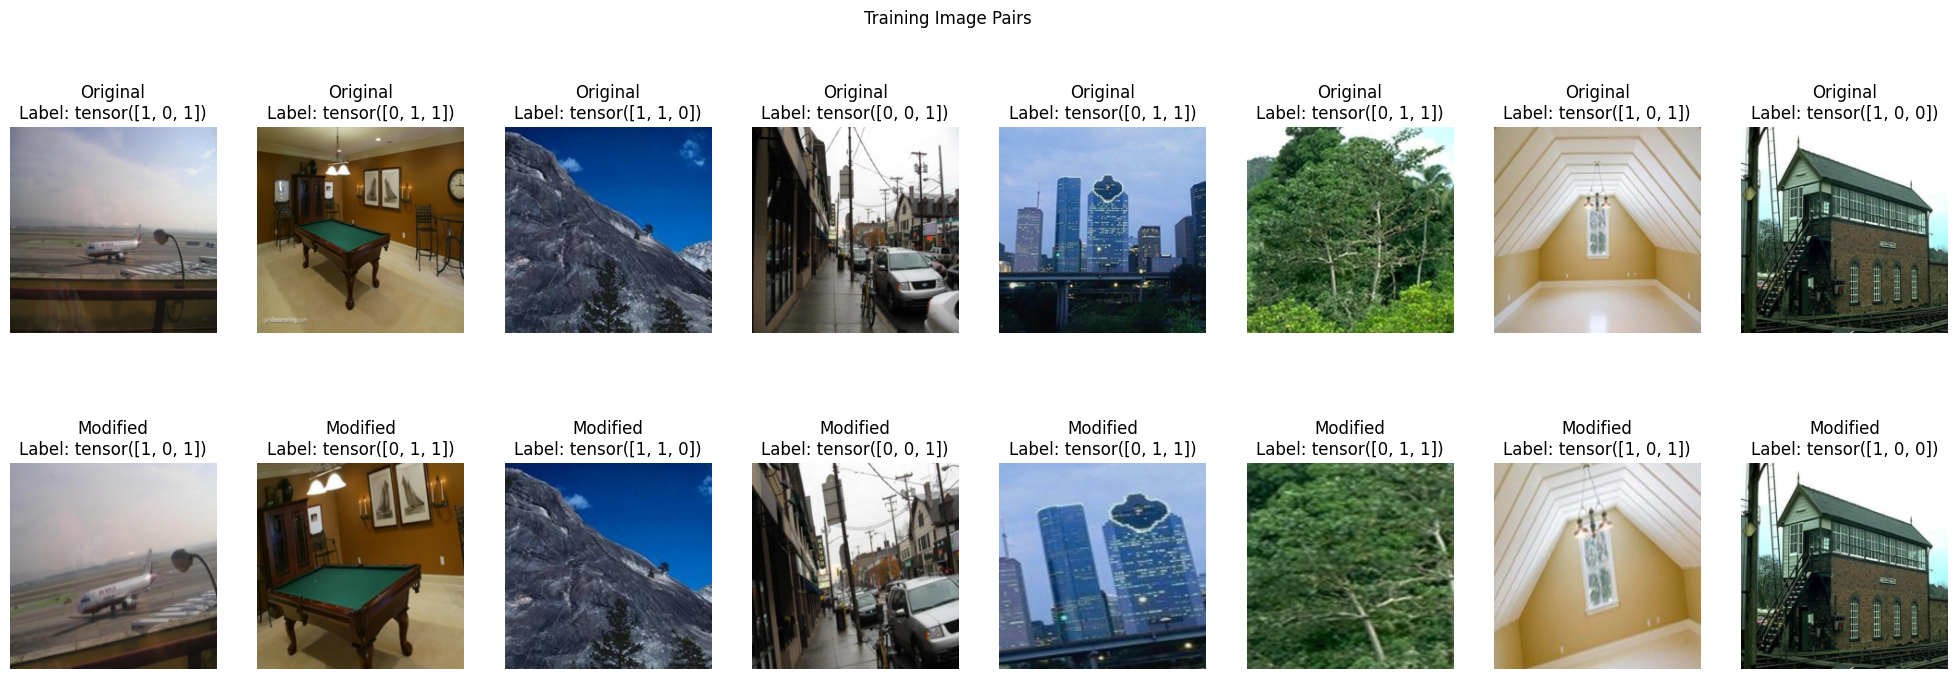

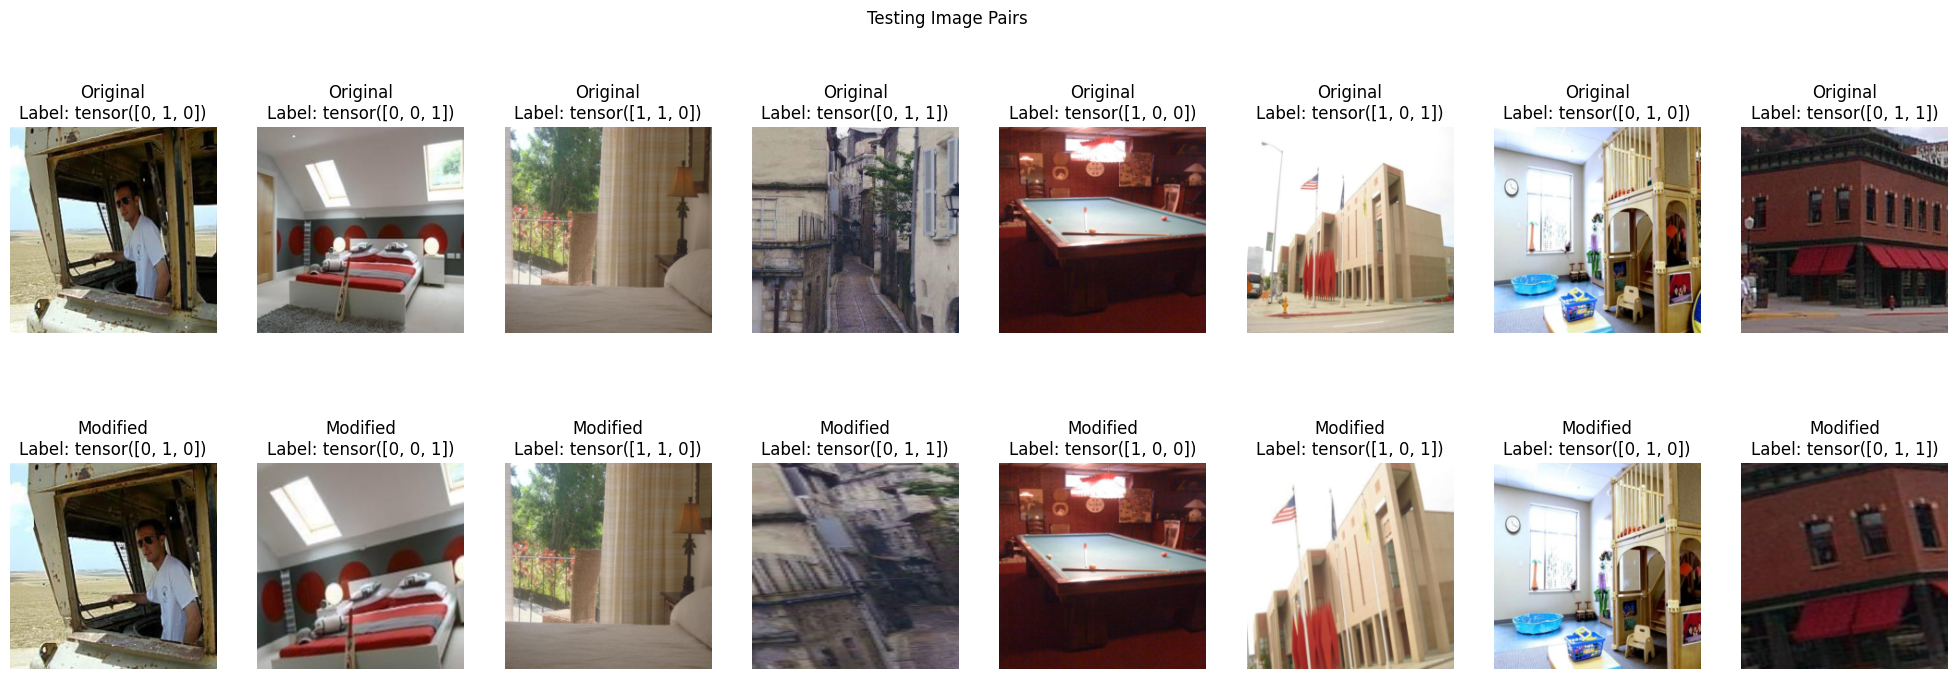

In [ ]:
import matplotlib.pyplot as plt

def show_image_pairs(data_loader, title, num_pairs=8):
    fig, axes = plt.subplots(2, num_pairs, figsize=(25, 8))
    fig.suptitle(title)

    for i, (original_images, modified_images, labels) in enumerate(data_loader):
        if i >= num_pairs:
            break

        np_original = original_images[i].numpy().transpose((1, 2, 0))
        np_modified = modified_images[i].numpy().transpose((1, 2, 0))
        axes[0, i].imshow(np_original)
        axes[0, i].axis('off')
        axes[0, i].set_title(f'Original\nLabel: {labels[i]}')

        axes[1, i].imshow(np_modified)
        axes[1, i].axis('off')
        axes[1, i].set_title(f'Modified\nLabel: {labels[i]}')

    plt.show()

show_image_pairs(train_loader, 'Training Image Pairs')

show_image_pairs(test_loader, 'Testing Image Pairs')


##Model

در این قسمت میخواهیم یک مدل 3 کلاسه  مطبق شکل زیرکه شامل قسمت های زیر میشود را آموزش دهیم.

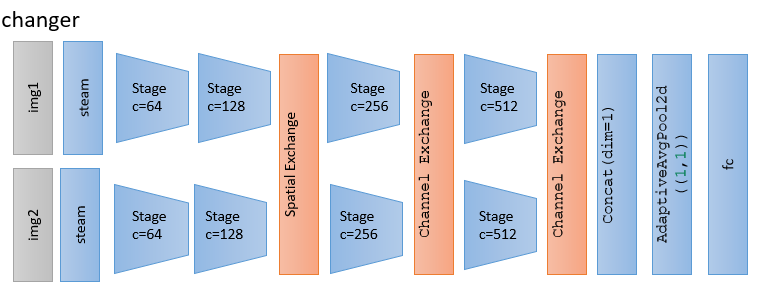

دو کلاس



1.   SpatialExchange
2.   ChannelExchange


 .مطابق شکل زیر ویژگی های دو تصویر را با هم عوض میکنند.


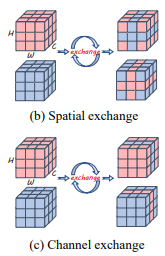

In [ ]:
## dont change this block

from mmengine.model import BaseModule
class ChannelExchange(BaseModule):
    """
    channel exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape

        exchange_map = torch.arange(c) % self.p == 0
        exchange_mask = exchange_map.unsqueeze(0).expand((N, -1))

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[~exchange_mask, ...] = x1[~exchange_mask, ...]
        out_x2[~exchange_mask, ...] = x2[~exchange_mask, ...]
        out_x1[exchange_mask, ...] = x2[exchange_mask, ...]
        out_x2[exchange_mask, ...] = x1[exchange_mask, ...]

        return out_x1, out_x2



class SpatialExchange(BaseModule):
    """
    spatial exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape
        exchange_mask = torch.arange(w) % self.p == 0

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[..., ~exchange_mask] = x1[..., ~exchange_mask]
        out_x2[..., ~exchange_mask] = x2[..., ~exchange_mask]
        out_x1[..., exchange_mask] = x2[..., exchange_mask]
        out_x2[..., exchange_mask] = x1[..., exchange_mask]

        return out_x1, out_x2

شبکه ی زیر را پیاده کنید  

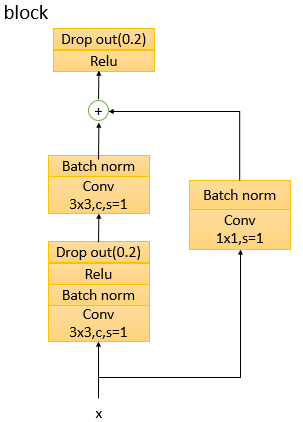

سوال تئوری1:
1.  مقادیر زیر را برای لایه های کانولوشن چه قدر در نظر گرفته اید؟


 >`channel out size (conv(1*1))`: I choose it to be `c` because it must be the same size as output of the left part of the block.

 >`padding(conv)`: I chose a padding of 1 to ensure that the output sizes of the left and right sides of the block remain the same. Given that the spatial dimension of the right side doesn’t change due to the conv(1×1) operation, a padding of 1 is necessary to maintain the same spatial dimension.


2.  دلیل استفاده از کانولوشن 1در1 چیست؟

>> دلیل استفاده از این نوع کانولوشن برای تغییر تعداد کانال می باشد.



In [ ]:

class block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(block, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels)
        )

        self.right =  nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1),
            nn.BatchNorm2d(out_channels)
        )
        self.result = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(0.2)
        )


    def forward(self, x):

        left = self.left(x)

        right = self.right(x)

        out = left + right
        out = self.result(out)
        return out


class steam(nn.Module):
    def __init__(self, in_channels, out_channels=64):
        super(steam, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

    def forward(self, x):
        return self.block(x)


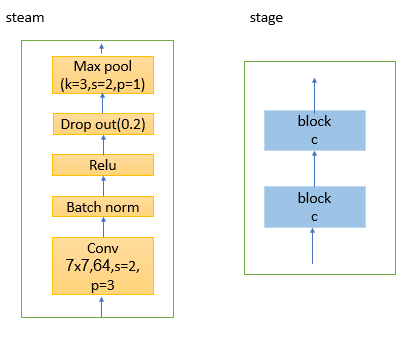

با استفاده از تصاویر مدل ،کلاس زیر را تکمیل کنید.

In [ ]:
import torch
import torch.nn as nn

class changer(nn.Module):
    def __init__(self, SpatialExchange, ChannelExchange, in_channels=3):
        super(changer, self).__init__()
        self.stage1 = nn.Sequential(
            steam(in_channels),
            block(64, 64),
            block(64, 64),
            block(64, 128),
            block(128, 128)
        )
        self.stage2 = nn.Sequential(
            block(128, 256),
            block(256, 256)
        )
        self.stage3 = nn.Sequential(
            block(256, 512),
            block(512, 512)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Linear(1024, 3)

    def forward(self, x1, x2):

        x1 = self.stage1(x1)

        x2 = self.stage1(x2)
        x1, x2 = SpatialExchange(x1, x2)
        x1 = self.stage2(x1)
        x2 = self.stage2(x2)
        x1, x2 = ChannelExchange(x1, x2)
        x1 = self.stage3(x1)
        x2 = self.stage3(x2)
        x1, x2 = ChannelExchange(x1, x2)
        out = torch.cat((x1, x2), 1)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)

        return out


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
SpatialExchange = SpatialExchange()
ChannelExchange = ChannelExchange()
model=changer(SpatialExchange, ChannelExchange).to(device)

##Train & validation


I'm training a model for 3 epochs using the Adam optimizer and the Binary Cross Entropy with Logits loss function. During each epoch, I process the images and labels from the training data loader, perform forward and backward propagation, and update the model parameters. I also calculate the accuracy for each label and the overall accuracy.


`Note:`The model was trained in multiple stages. Initially, it was trained for 10 epochs and the model was saved. Subsequently, it was trained for an additional 5 epochs, and finally for 2 more epochs.

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00014)
model.train()
loss_values = []
accuracy_values = []
for epoch in range(3):
    running_loss = 0.0
    correct = 0
    total = 0
    accuracy_per_label = 0
    overall_accuracy = 0
    for i, data in enumerate(train_loader, 0):

        original_images, modified_images, labels = data

        original_images = original_images.to(device)
        modified_images = modified_images.to(device)
        labels = labels.to(device)
        labels = labels.float()

        optimizer.zero_grad()

        outputs = model(original_images, modified_images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        probabilities = torch.sigmoid(outputs)


        threshold = 0.5
        predicted = (probabilities >= threshold).float()

        correct_predictions = (predicted == labels).float()

        accuracy_per_label += correct_predictions.sum(0)/len(original_images)

        overall_accuracy += correct_predictions.sum()/(len(original_images)*3)
        running_loss += loss.item()

    torch.save(model.state_dict(), 'model_parameters.pth')
    accuracy_per_label = accuracy_per_label/len(train_loader)
    overall_accuracy = overall_accuracy/(len(train_loader))
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}, '
        f'Accuracy per label: {accuracy_per_label.tolist()}, '
        f'Overall Accuracy: {overall_accuracy.item() * 100}%')

print('Finished Training')


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_values)
plt.title('Loss versus Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(accuracy_values)
plt.title('Accuracy versus Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

Epoch 1, Loss: 0.2796794461146858, Accuracy per label: [0.6909074187278748, 0.8462278246879578, 0.9978721141815186], Overall Accuracy: 84.50016379356384%
Epoch 2, Loss: 0.2760841435415822, Accuracy per label: [0.6909710168838501, 0.8516853451728821, 0.9984164834022522], Overall Accuracy: 84.70247387886047%


# save model

In [ ]:
torch.save(model.state_dict(), 'model_parameters.pth')

# load model

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
SpatialExchange = SpatialExchange()
ChannelExchange = ChannelExchange()
model=changer(SpatialExchange, ChannelExchange).to(device)

model.load_state_dict(torch.load('model_parameters.pth'))

model.eval()

changer(
  (stage1): Sequential(
    (0): steam(
      (block): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.2, inplace=False)
        (4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      )
    )
    (1): block(
      (left): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.2, inplace=False)
        (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (right): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, m

#Test


Finally, we evaluate our model using test set.

In [ ]:
model.eval()

accuracy_per_label_test = torch.zeros(3).to(device)
overall_accuracy_test = 0

with torch.no_grad():
    for data in test_loader:
        original_images, modified_images, labels = data
        original_images = original_images.to(device)
        modified_images = modified_images.to(device)
        labels = labels.to(device)
        labels = labels.float()

        outputs = model(original_images, modified_images)

        probabilities = torch.sigmoid(outputs)

        threshold = 0.5
        predicted = (probabilities >= threshold).float()

        correct_predictions = (predicted == labels).float()

        accuracy_per_label_test += correct_predictions.sum(0)/(len(original_images))

        overall_accuracy_test += correct_predictions.sum()/(len(original_images)*3)


accuracy_per_label_test /= len(test_loader)

overall_accuracy_test /= len(test_loader)

print(f'Accuracy per label: {accuracy_per_label_test.tolist()}, '
      f'Overall Accuracy: {overall_accuracy_test.item() * 100}%')


Accuracy per label: [0.6470238566398621, 0.8440476655960083, 0.9997023940086365], Overall Accuracy: 83.02581906318665%
